## Compare pairs screened + hits identified in each GI screen

Combinatorial screens: Thompson et al., Dede et al., Parrish et al., Gonatopoulos-Pournatzis (CHyMErA)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Input
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')

file_thompson_pairs = get_local_data_path(['processed', 'screen_pairs'], 'thompson_pairs.csv')
file_dede_pairs = get_local_data_path(['processed', 'screen_pairs'], 'dede_pairs.csv')
file_chymera_orig = get_local_data_path(['processed','screen_pairs'], 'chymera_pairs_orig.csv')
file_parrish_pairs = get_local_data_path(['processed','screen_pairs'], 'parrish_pairs.csv')


# Output
file_chymera_new = get_local_data_path(['processed','screen_pairs'], 'chymera_pairs_filtered.csv')
file_all_screened_pairs = get_local_data_path(['processed', 'screen_pairs'], 'all_screened_pairs.csv')
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')

### Load data sets

In [16]:
annot = pd.read_csv(file_annot_pairs)[['sorted_gene_pair','min_sequence_identity','family_size','WGD','closest']]
annot.min_sequence_identity = annot.min_sequence_identity * 100
print('N=', annot.shape[0])
annot[:1]

N= 36648


,sorted_gene_pair,min_sequence_identity,family_size,WGD,closest
0,A1BG_OSCAR,12.7273,3,False,False


In [17]:
depmap_pairs = pd.read_csv(file_depmap_pairs)
depmap_pairs = pd.merge(depmap_pairs, annot)
print('N:', depmap_pairs.shape[0])
depmap_pairs[:1]

N: 3634


,sorted_gene_pair,SL,min_sequence_identity,family_size,WGD,closest
0,AAK1_BMP2K,False,34.1947,2,False,True


In [18]:
all_thompson_pairs = pd.read_csv(file_thompson_pairs)
thompson_pairs_full = pd.merge(all_thompson_pairs, annot)
print('N full:', thompson_pairs_full.shape[0])
print('N w/ essential gene:', thompson_pairs_full[thompson_pairs_full.passes_min_1_filter==False].shape[0])
thompson_pairs = thompson_pairs_full[thompson_pairs_full.passes_min_1_filter].reset_index(drop=True)
print('N after filtering:', thompson_pairs.shape[0])
print('SL 1+: %d = %.1f%%' % (sum(thompson_pairs.n_SL>=1), sum(thompson_pairs.n_SL>=1)/thompson_pairs.shape[0]*100))
print('SL 2+: %.1f%%' % (sum(thompson_pairs.n_SL>=2)/thompson_pairs.shape[0]*100))

N full: 592
N w/ essential gene: 117
N after filtering: 475
SL 1+: 71 = 14.9%
SL 2+: 4.8%


In [19]:
all_dede_pairs = pd.read_csv(file_dede_pairs)
dede_pairs = pd.merge(all_dede_pairs, annot)
print('N:', dede_pairs.shape[0])
print('SL 1+: %d = %.1f%%' % (sum(dede_pairs.n_SL>=1), sum(dede_pairs.n_SL>=1)/dede_pairs.shape[0]*100))
print('SL 2+: %.1f%%' % (sum(dede_pairs.n_SL>=2)/dede_pairs.shape[0]*100))

N: 393
SL 1+: 24 = 6.1%
SL 2+: 4.8%


In [20]:
all_parrish_pairs = pd.read_csv(file_parrish_pairs)
parrish_pairs = pd.merge(all_parrish_pairs, annot)
print('N:', parrish_pairs.shape[0])
print('SL 1+: %d = %.1f%%' % (sum(parrish_pairs.n_SL>=1), sum(parrish_pairs.n_SL>=1)/parrish_pairs.shape[0]*100))
print('SL 2: %.1f%%' % (sum(parrish_pairs.n_SL==2)/parrish_pairs.shape[0]*100))

N: 1027
SL 1+: 122 = 11.9%
SL 2: 3.4%


In [21]:
all_chymera_pairs_orig = pd.read_csv(file_chymera_orig, index_col=0)
chymera_pairs_orig = pd.merge(all_chymera_pairs_orig, annot)
print('N:', chymera_pairs_orig.shape[0])
print('SL 1+: %d = %.1f%%' % (sum(chymera_pairs_orig.n_hits>=1), 
                              sum(chymera_pairs_orig.n_hits>=1)/chymera_pairs_orig.shape[0]*100))
print('SL 2: %.1f%%' % (sum(chymera_pairs_orig.n_hits==2)/chymera_pairs_orig.shape[0]*100))
# Rename hit column for easier comparison
chymera_pairs_orig = chymera_pairs_orig.rename(columns={'n_hits':'n_SL'})

N: 658
SL 1+: 267 = 40.6%
SL 2: 7.6%


### Ensembl version comparison
Check which Ensembl version covers more of the screened paralog pairs.

In [22]:
cols = ['sorted_gene_pair','in_93','in_102']
df = pd.merge(all_thompson_pairs[cols], all_dede_pairs[cols], how='outer')
df = pd.merge(df, all_parrish_pairs[cols], how='outer')
df = pd.merge(df, all_chymera_pairs_orig[cols], how='outer')
print('All pairs screened in at least 1 study, Ensembl 93:', df[df.in_93].shape[0])
print('All pairs screened in at least 1 study, Ensembl 102:', df[df.in_102].shape[0])

All pairs screened in at least 1 study, Ensembl 93: 1915
All pairs screened in at least 1 study, Ensembl 102: 1874


### Bias in screened paralog pairs

In [23]:
# All datasets: all pairs in all screens + our depmap set + reference (all paralog pairs)
cols = ['sorted_gene_pair','min_sequence_identity','family_size', 'WGD', 'closest']
all_datasets = pd.concat([annot[cols].assign(screen='All paralog\npairs'), depmap_pairs[cols].assign(screen='Our dataset'),
                         thompson_pairs_full[cols].assign(screen='Thompson'), dede_pairs[cols].assign(screen='Dede'), 
                         parrish_pairs[cols].assign(screen='Parrish'), chymera_pairs_orig[cols].assign(screen='CHyMErA')])
print('N=', all_datasets.shape[0])
all_datasets[:1]

N= 42952


,sorted_gene_pair,min_sequence_identity,family_size,WGD,closest,screen
0,A1BG_OSCAR,12.7273,3,False,False,All paralog\npairs


In [24]:
data_order = ['All paralog\npairs','Our dataset','Thompson','Dede','Parrish','CHyMErA']
data_palette = ['grey','silver'] + gp.get_palette('okabe-ito-2')[:4]

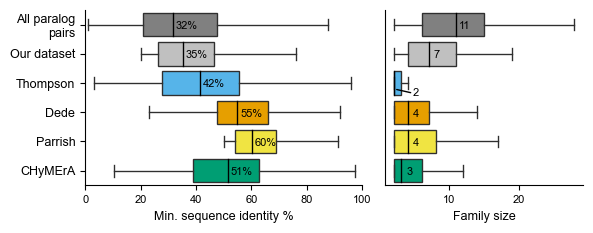

In [60]:
f, ax = plt.subplots(1, 2, figsize=(6,2.4), sharey=True, gridspec_kw={'width_ratios':[1.4,1]})

# 1/ Seq id plot
sns.boxplot(x='min_sequence_identity', y='screen', data=all_datasets, showfliers=False, ax=ax[0], 
            palette=data_palette, saturation=1, linewidth=0.98, medianprops=dict(linewidth=0.98, color='black'))
gp.set_axis_props(ax[0], xlabel='Min. sequence identity %', ylabel='', ytick_fontsize=9)
ax[0].set_xlim([0,100])  

# Annotate graph with medians
medians = all_datasets.groupby(['screen'])['min_sequence_identity'].median()[data_order]
labels = ["%.f%%" % i for i in medians.values]
for tick in ax[0].get_yticks():
    ax[0].text(medians[tick]+5, tick+0.15, labels[tick], ha='center', size=8, color='black')


# 2/ Family plot
sns.boxplot(x='family_size', y='screen', data=all_datasets, showfliers=False, ax=ax[1], 
            palette=data_palette, saturation=1, linewidth=0.98, medianprops=dict(linewidth=0.98, color='black'))
gp.set_axis_props(ax[1], xlabel='Family size', ylabel='', show_yticks=False)

# Annotate graphs with medians
medians = all_datasets.groupby(['screen'])['family_size'].median()[data_order]
labels = ["%d" % i for i in medians.values]
for tick in ax[1].get_yticks():
    if tick == 2:
            ax[1].text(medians[tick]+3.2, tick+0.45, labels[tick], ha='center', size=8)
            ax[1].annotate("", xy=(medians[tick], tick+0.2), xytext=(medians[tick]+2.8, tick+0.35), 
                           arrowprops=dict(arrowstyle="-"))
    else:
        ax[1].text(medians[tick]+1.2, tick+0.15, labels[tick], ha='center', size=8, color='black')

plt.tight_layout()
f.savefig("../figures/for_paper/bias_seq_id_family_size.svg", bbox_inches="tight", dpi=300)

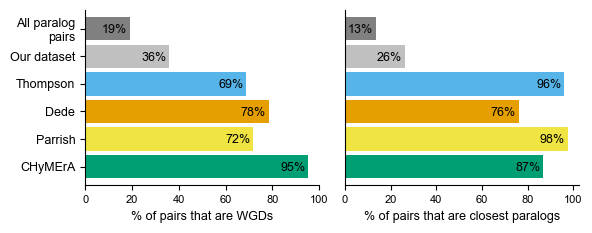

In [61]:
f, ax = plt.subplots(1,2,figsize=(6,2.4), sharey=True)

# 1/ WGD
ctab = pd.crosstab(all_datasets.WGD, all_datasets.screen)
ctab = ctab.div(ctab.sum(axis=0)).multiply(100).loc[:, data_order[::-1]]
ctab.iloc[1].plot.barh(ax=ax[0], width=0.85, rot=0, color=data_palette[::-1])
gp.set_axis_props(ax[0], ytick_fontsize=9, ylabel='', xlabel='% of pairs that are WGDs')

# Annotations
labels = ["%.f%%" % i for i in ctab.iloc[1].values]
for rect, label in zip(ax[0].patches, labels):
    xoffset = rect.get_width()-(ctab.values.max()*0.023*len(label))
    ax[0].text(rect.get_x()+xoffset, rect.get_y()+rect.get_height()/2-0.05, label, ha='center', va='center')
    
# 2/ closest  
ctab = pd.crosstab(all_datasets.closest, all_datasets.screen)
ctab = ctab.div(ctab.sum(axis=0)).multiply(100).loc[:, data_order[::-1]]
ctab.iloc[1].plot.barh(ax=ax[1], width=0.85, rot=0, color=data_palette[::-1])
gp.set_axis_props(ax[1], ytick_fontsize=9, show_yticks=False, ylabel='', xlabel='% of pairs that are closest paralogs')

# Annotations
labels = ["%.f%%" % i for i in ctab.iloc[1].values]
for rect, label in zip(ax[1].patches, labels):
    xoffset = rect.get_width()-(ctab.values.max()*0.023*len(label))
    ax[1].text(rect.get_x()+xoffset, rect.get_y()+rect.get_height()/2-0.05, label, ha='center', va='center')

plt.tight_layout()
f.savefig("../figures/for_paper/bias_wgd_closest.svg", bbox_inches="tight", dpi=300)

In [41]:
# Identify unique list of screened pairs (from the four studies)
all_screened = all_datasets[all_datasets.screen.isin(['Thompson','Dede','Parrish','CHyMErA'])]
all_screened = all_screened.drop(columns=['screen']).drop_duplicates()

print('Median seq. id. all: %.f%%, screened: %.f%%' % 
      (annot.min_sequence_identity.median(), all_screened.min_sequence_identity.median()))
print('Median family size all: %d, screened: %d' % (annot.family_size.median(), all_screened.family_size.median()))
print('%% WGDs all: %.f%%, screened: %.f%%' % 
      (sum(annot.WGD)/annot.shape[0]*100, sum(all_screened.WGD)/all_screened.shape[0]*100))
print('%% closest all: %.f%%, screened: %.f%%' % 
      (sum(annot.closest)/annot.shape[0]*100, sum(all_screened.closest)/all_screened.shape[0]*100))

Median seq. id. all: 32%, screened: 54%
Median family size all: 11, screened: 3
% WGDs all: 19%, screened: 73%
% closest all: 13%, screened: 89%


### Pick threshold for Chymera pairs
Based on overlap with the three other screens

In [42]:
chymera_pairs_orig[:1]

,sorted_gene_pair,hap1_hit,rpe1_hit,n_SL,min_hap1_lfc,min_rpe1_lfc,in_93,in_102,min_sequence_identity,family_size,WGD,closest
0,SEC23A_SEC23B,True,True,2,-2.079895,-1.96918,True,True,84.6154,2,True,True


In [43]:
# Try different observed LFC thresholds and check FET overlap with the three other screens
thresholds = np.arange(-0.6, -1.3, -0.1)
screen_names = ['Thompson','Dede','Parrish']
fet_results = pd.DataFrame(columns=['lfc_threshold','screen','-log10(p)','OR'])
idx = 0
for t in thresholds:
    df = chymera_pairs_orig.assign(hap1_SL = chymera_pairs_orig.apply(lambda x: x.hap1_hit and (x.min_hap1_lfc <= t), axis=1),
                                   rpe1_SL = chymera_pairs_orig.apply(lambda x: x.rpe1_hit and (x.min_rpe1_lfc <= t), axis=1))
    df['n_SL'] = df[['hap1_SL','rpe1_SL']].sum(axis=1)
    for i, screen in enumerate([thompson_pairs, dede_pairs, parrish_pairs]):
        overlap = pd.merge(df[['sorted_gene_pair','n_SL']], screen[['sorted_gene_pair','n_SL']], on=['sorted_gene_pair'])
        ctab = pd.crosstab(overlap.n_SL_x > 0, overlap.n_SL_y > 0)
        fet_results.loc[idx] = [t, screen_names[i], -np.log(stats.fisher_exact(ctab)[1]), stats.fisher_exact(ctab)[0]]
        idx += 1
fet_results[:2]

,lfc_threshold,screen,-log10(p),OR
0,-0.6,Thompson,5.805529,4.017751
1,-0.6,Dede,7.219934,9.411765


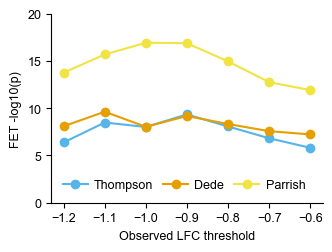

In [62]:
f, ax = plt.subplots(1,1,figsize=(3.4,2.6))
tab = fet_results.pivot_table("-log10(p)", "lfc_threshold", "screen").loc[:, data_order[2:5]]
tab.plot(marker="o", ax=ax, color=data_palette[2:5], linewidth=1.5)
ax.legend(loc='lower left', bbox_to_anchor=(0,0), ncol=3, columnspacing=0.8, handletextpad=0.5, fontsize=9)
gp.set_axis_props(ax, ytick_fontsize=9, xtick_fontsize=9, ylabel='FET -log10(p)', xlabel='Observed LFC threshold')
ax.set_ylim([0,20])
plt.tight_layout()
f.savefig("../figures/for_paper/chymera_overlap_fet.svg", bbox_inches="tight", dpi=300)

In [45]:
# Make and save the filtered Chymera dataset based on the best threshold
#[['sorted_gene_pair','hap1_SL','rpe1_SL','min_hap1_lfc','min_rpe1_lfc']]
threshold = -0.9
chymera_pairs = chymera_pairs_orig.assign(
    hap1_SL = chymera_pairs_orig.apply(lambda x: x.hap1_hit and (x.min_hap1_lfc <= threshold), axis=1),
    rpe1_SL = chymera_pairs_orig.apply(lambda x: x.rpe1_hit and (x.min_rpe1_lfc <= threshold), axis=1))

chymera_pairs['n_SL'] = chymera_pairs[['hap1_SL','rpe1_SL']].sum(axis=1)
chymera_pairs = chymera_pairs[['sorted_gene_pair','hap1_SL','rpe1_SL','n_SL']]
print('N:', chymera_pairs.shape[0])
print('SL 1+: %d, %.2f%%' % (sum(chymera_pairs.n_SL>=1), sum(chymera_pairs.n_SL>=1)/chymera_pairs.shape[0]*100))
print('SL 2: %d, %.2f%%' % (sum(chymera_pairs.n_SL==2), sum(chymera_pairs.n_SL==2)/chymera_pairs.shape[0]*100))
chymera_pairs.to_csv(file_chymera_new, index=0)
display(chymera_pairs[:1])
chymera_pairs = pd.merge(chymera_pairs, annot)

N: 658
SL 1+: 72, 10.94%
SL 2: 10, 1.52%


,sorted_gene_pair,hap1_SL,rpe1_SL,n_SL
0,SEC23A_SEC23B,True,True,2


### Screen hit rates

,hit_rate
Thompson,14.947368
Dede,6.106870
Parrish,11.879260
CHyMErA\n(unfiltered),40.577508
CHyMErA\n(filtered),10.942249


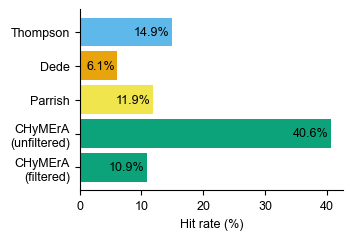

In [63]:
hit_rates = pd.DataFrame()
screen_names = ['Thompson', 'Dede', 'Parrish', 'CHyMErA\n(unfiltered)', 'CHyMErA\n(filtered)']
for i, pairs in enumerate([thompson_pairs, dede_pairs, parrish_pairs, chymera_pairs_orig, chymera_pairs]):
    hit_rates = pd.concat([hit_rates, pd.DataFrame({'hit_rate':sum(pairs.n_SL>=1)/pairs.shape[0]*100},
                                                   index=[screen_names[i]])])
display(hit_rates)

f, ax = plt.subplots(1, 1, figsize=(3.4,2.4))
pal = data_palette[5:6]+data_palette[::-1]
hit_rates[::-1].hit_rate.plot.barh(ax=ax, rot=0, width=0.85, color=pal, alpha=0.95)
gp.set_axis_props(ax, xlabel='Hit rate (%)', ytick_fontsize=9, xtick_fontsize=9)

labels = ["%.1f%%" % i for i in hit_rates[::-1].hit_rate.values]
for rect, label in zip(ax.patches, labels):
    ax.text(rect.get_x()+(rect.get_width())-0.4, rect.get_y()+(rect.get_height()/2), label, ha='right', va='center')
f.savefig("../figures/for_paper/hit_rates.svg", bbox_inches="tight", dpi=300)

### All screened pairs & screen consensus pairs

In [47]:
# Merge all pairs screened in at least 1 study
cols = ['sorted_gene_pair','n_SL']
all_screened_pairs = pd.merge(thompson_pairs[cols].rename(columns={'n_SL':'n_SL_thompson'}), 
                              dede_pairs[cols].rename(columns={'n_SL':'n_SL_dede'}), how='outer')
all_screened_pairs = pd.merge(all_screened_pairs, parrish_pairs[cols].rename(columns={'n_SL':'n_SL_parrish'}), how='outer')
all_screened_pairs = pd.merge(all_screened_pairs, chymera_pairs[cols].rename(columns={'n_SL':'n_SL_chymera'}), how='outer')

# Check n SL
assert(sum(all_screened_pairs.n_SL_thompson>0) == sum(thompson_pairs.n_SL>0))
assert(sum(all_screened_pairs.n_SL_parrish>0) == sum(parrish_pairs.n_SL>0))

# Count screens in which pair was tested (4 - NA cols) and was found to be a hit
cols = ['n_SL_thompson','n_SL_dede','n_SL_parrish','n_SL_chymera']
all_screened_pairs['n_screens'] = 4 - all_screened_pairs[cols].isna().sum(axis=1)
all_screened_pairs['n_screens_SL'] = all_screened_pairs.apply(lambda x: ((x.n_SL_thompson>=1)+(x.n_SL_dede>=1)+
                                                                         (x.n_SL_parrish>=1)+(x.n_SL_chymera>=1)), axis=1)

print('N pairs screened in at least 1 study:', all_screened_pairs.shape[0])
print('N pairs a hit in at least 1 study:', sum(all_screened_pairs.n_screens_SL>0))

# Save
all_screened_pairs.to_csv(file_all_screened_pairs, index=0)
all_screened_pairs[:2]

N pairs screened in at least 1 study: 1845
N pairs a hit in at least 1 study: 224


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0
1,MIB1_MIB2,0.0,NaN,NaN,NaN,1,0


In [48]:
df = pd.merge(all_screened_pairs, thompson_pairs_full, how='outer')
print('N pairs screened in at least 1 study (Thompson unfiltered):', df.shape[0])
print('%% of all paralog pairs screened in at least 1 study (Thompson unfiltered): %.2f%%' % (df.shape[0]/annot.shape[0]*100))

N pairs screened in at least 1 study (Thompson unfiltered): 1915
% of all paralog pairs screened in at least 1 study (Thompson unfiltered): 5.23%


In [49]:
# Filter to pairs screened in at least two studies (NA in less than two studies)
consensus_pairs = all_screened_pairs[all_screened_pairs.n_screens >= 2].reset_index(drop=True)
print('N paralog pairs screened in at least 2 studies:', consensus_pairs.shape[0])

# Find pairs SL in at least 2 studies vs. pairs that were not hits in any studies (but screened in at least two)
consensus_pairs = consensus_pairs.assign(SL = (consensus_pairs.n_screens_SL >= 2),
                                         non_SL = (consensus_pairs.n_screens_SL == 0))
print('n TP:', sum(consensus_pairs.SL))
print('n TN:', sum(consensus_pairs.non_SL))

# Only keep the TP and TN
consensus_pairs = consensus_pairs[consensus_pairs.SL | consensus_pairs.non_SL].reset_index(drop=True)
assert(sum(consensus_pairs.non_SL)==sum(consensus_pairs.SL==False))
consensus_pairs = consensus_pairs.drop(columns=['non_SL'])

# Save
consensus_pairs.to_csv(file_consensus_pairs, index=0)

print('Consensus dataset: %d/%d = %.2f%%' % (sum(consensus_pairs.SL), consensus_pairs.shape[0], 
                                              sum(consensus_pairs.SL)/consensus_pairs.shape[0]*100))
consensus_pairs[:1]

N paralog pairs screened in at least 2 studies: 545
n TP: 50
n TN: 407
Consensus dataset: 50/457 = 10.94%


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,False


### Number of hits shared across cell lines in each screen

In [50]:
hits_df = pd.DataFrame()
for screen in ['Thompson', 'Dede', 'Parrish', 'Chymera']:
    n_SL_col = 'n_SL_'+screen.lower()
    hits_df = pd.concat([hits_df, pd.DataFrame({
        'hit_rate':sum(all_screened_pairs[n_SL_col]>=1)/sum(~all_screened_pairs[n_SL_col].isna())*100,
        'num_hits':sum(all_screened_pairs[n_SL_col]>=1),
        '1':sum(all_screened_pairs[n_SL_col]==1)/sum(all_screened_pairs[n_SL_col]>=1)*100,
        '2':sum(all_screened_pairs[n_SL_col]==2)/sum(all_screened_pairs[n_SL_col]>=1)*100,
        '3':sum(all_screened_pairs[n_SL_col]==3)/sum(all_screened_pairs[n_SL_col]>=1)*100,
        '2-3':sum(all_screened_pairs[n_SL_col]>=2)/sum(all_screened_pairs[n_SL_col]>=1)*100}, index=[screen])])
    
print('Median hit rate: %.2f%%' % (hits_df.hit_rate.median()))
display(hits_df)

Median hit rate: 11.41%


,hit_rate,num_hits,1,2,3,2-3
Thompson,14.947368,71,67.605634,19.718310,12.676056,32.394366
Dede,6.106870,24,20.833333,20.833333,58.333333,79.166667
Parrish,11.879260,122,71.311475,28.688525,0.000000,28.688525
Chymera,10.942249,72,86.111111,13.888889,0.000000,13.888889


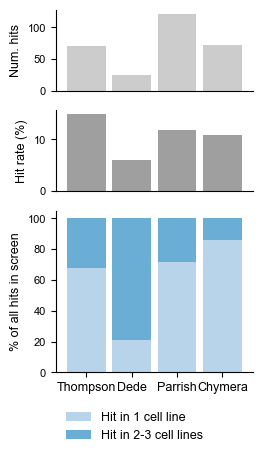

In [64]:
f, ax = plt.subplots(3, 1, figsize=(2.7,4.6), gridspec_kw={'height_ratios':[1,1,2]}, sharex=True)

# Num hits
hits_df.num_hits.plot(kind='bar', stacked=True, ax=ax[0], color='#ccc', rot=0, width=0.85)
gp.set_axis_props(ax[0], ylabel='Num. hits', show_xticks=False)

# Percent of screened pairs that are hits (hit rate)
hits_df.hit_rate.plot(kind='bar', stacked=True, ax=ax[1], color="#777", alpha=0.7, rot=0, width=0.85)
gp.set_axis_props(ax[1], ylabel='Hit rate (%)', show_xticks=False)

# Breakdown of hits
blues_pal = [b for i, b in enumerate(sns.color_palette("Blues", n_colors=9)) if i==2 or i==4]
hits_df.loc[:,['1','2-3']].plot(kind='bar', stacked=True, ax=ax[2], color=blues_pal, rot=0, width=0.85)
gp.set_axis_props(ax[2], ylabel='% of all hits in screen', xtick_fontsize=9)
ax[2].legend(loc="lower center", bbox_to_anchor=(0.4,-0.5), labels=['Hit in 1 cell line', 'Hit in 2-3 cell lines'], fontsize=9)
#_ = ax[2].set_xticklabels(['Thompson   ', ' Dede', 'Parrish ', '   CHyMErA'])

plt.tight_layout()
f.savefig("../figures/for_paper/cell_line_specific_hits.svg", bbox_inches="tight", dpi=300)

### Screen to screen overlap

In [66]:
screen_names = ['Thompson','Dede','Parrish','CHyMErA']
screen_colors = gp.get_palette('okabe-ito-2')
# All pairwise screens combos
screen_pairs = [pair for pair in itertools.combinations(screen_names, r=2)]

hits_overlap_df = pd.DataFrame()
for p in screen_pairs:
    col1 = 'n_SL_'+p[0].lower(); col2 = 'n_SL_'+p[1].lower()
    df = all_screened_pairs[(~all_screened_pairs[col1].isna()) & (~all_screened_pairs[col2].isna())]
    hits_overlap_df = pd.concat([hits_overlap_df, pd.DataFrame(
        {'Shared hits': sum((df[col1]>0)&(df[col2]>0)) / sum((df[col1]>0)|(df[col2]>0))*100,
         'Unique hits': sum((df[col1]>0)^(df[col2]>0)) / sum((df[col1]>0)|(df[col2]>0))*100}, index=[p[0]+p[1]])])

print('Mean %% shared hits: %.2f %%' % (hits_overlap_df['Shared hits'].mean()))
display(hits_overlap_df)

Mean % shared hits: 31.13 %


,Shared hits,Unique hits
ThompsonDede,18.750000,81.250000
ThompsonParrish,43.859649,56.140351
ThompsonCHyMErA,31.111111,68.888889
DedeParrish,27.777778,72.222222
DedeCHyMErA,33.333333,66.666667
ParrishCHyMErA,31.944444,68.055556


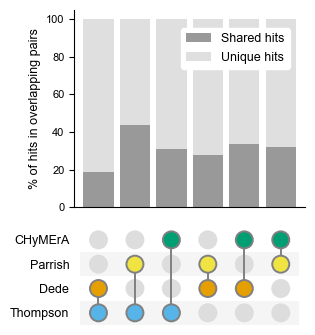

In [67]:
# Compute index pairs to color in - set circles to light grey unless in idx
idx = np.array([[screen_names.index(p[0])+(i*4), screen_names.index(p[1])+(i*4)] for i,p in enumerate(screen_pairs)]).flatten()
c = np.array(['#ddd'] * len(screen_pairs) * len(screen_names), dtype='O')
c[idx] = [screen_colors[i%4] for i in idx]
# Set circle border color
c_border = np.array(['#ddd'] * len(screen_pairs) * len(screen_names), dtype='O')
c_border[idx] = ['grey' for i in idx]
# x-y grid is screen pairs by screens
x = np.repeat(np.arange(len(screen_pairs)), len(screen_names))
y = np.tile(np.arange(len(screen_names)), len(screen_pairs))

f, (ax1,ax2) = plt.subplots(2, 1, figsize=(3,3.2), gridspec_kw={'height_ratios': [1.8, 1]}, sharex=True)
# Grid for overlaps
ax2.scatter(x, y, c=c.tolist(), edgecolor=c_border.tolist(), linewidth=1.4, s=150, zorder=1)
# Draw lines between the circles
line_data = (pd.Series(y[idx], index=x[idx]).groupby(level=0).aggregate(['min', 'max']))
ax2.vlines(line_data.index.values, line_data['min']+0.32, line_data['max']-0.32, lw=1.4, colors='grey')

# Set ticks
ax2.yaxis.set_ticks(np.arange(len(screen_names)))
ax2.yaxis.set_ticklabels(screen_names, rotation=0, fontsize=9)
ax2.xaxis.set_visible(False)
ax2.tick_params(axis='both', which='both', length=0)
ax2.set_frame_on(False)
ax2.set_xlim([-0.5,len(screen_pairs)]); ax2.set_ylim([-0.5, len(screen_names)])

# Color background
for i in range(0, 4, 2):
    rect = plt.Rectangle([-0.5,-0.5+i], 6, 1, facecolor='#f5f5f5', lw=0, zorder=0)
    ax2.add_patch(rect)

# Plot top part of graph
hits_overlap_df.plot.bar(ax=ax1, color=['#999','#dfdfdf'], width=0.83, stacked=True)
gp.set_axis_props(ax1, show_xticks=False, ylabel='% of hits in overlapping pairs')
ax1.legend(loc='upper right', framealpha=1, bbox_to_anchor=(0.96,0.94))
plt.tight_layout(pad=0.2)
f.savefig("../figures/for_paper/screen_overlaps.svg", bbox_inches="tight", dpi=300)

Thompson/Dede - FET: OR=6.5455, p=0.06530936
Thompson/Parrish - FET: OR=9.4118, p=0.00000003
Thompson/Chymera - FET: OR=6.2821, p=0.00008856
Dede/Parrish - FET: OR=18.4058, p=0.00000617
Dede/Chymera - FET: OR=14.1667, p=0.00010448
Parrish/Chymera - FET: OR=7.6949, p=0.00000005


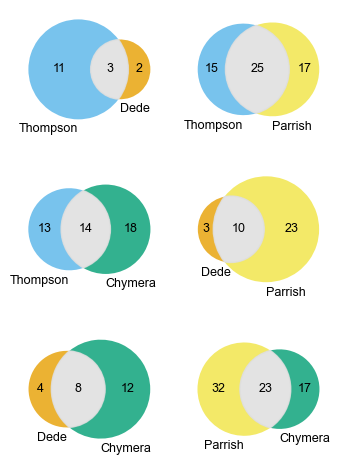

In [68]:
f, ax = plt.subplots(3, 2, figsize=(4,6))
ax = ax.flatten()

screen_tuples = [t for t in itertools.combinations(['Thompson','Dede','Parrish','Chymera'], r=2)]
screen_color_dict = {'Thompson':'#56b4e9', 'Dede':'#e69f00', 'Parrish':'#f0e442', 'Chymera':'#009e73'}

for i, t in enumerate(screen_tuples):
    col1='n_SL_'+t[0].lower(); col2='n_SL_'+t[1].lower()
    df = all_screened_pairs[~all_screened_pairs[col1].isna() & ~all_screened_pairs[col2].isna()]
    ctab = pd.crosstab(df[col1] > 0, df[col2] > 0)
    print(t[0]+'/'+t[1]+' - FET: OR=%.4f, p=%.8f' % (stats.fisher_exact(ctab)))
    
    v = venn2([set(df[df[col1]>0].sorted_gene_pair), set(df[df[col2]>0].sorted_gene_pair)], [t[0],t[1]], ax=ax[i], 
          set_colors=[screen_color_dict[t[0]], screen_color_dict[t[1]]], alpha=0.8)
    v.get_patch_by_id('11').set_color('#ddd')
    for text in v.set_labels: text.set_fontsize(9)

### RPE-1 Overlap

Chymera pairs new - FET: OR=1.8370, p=0.36115
Shared: 2 = 7.69%


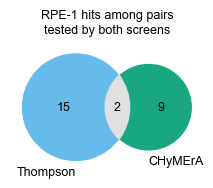

In [69]:
f, ax = plt.subplots(1, 1, figsize=(2.5,1.8))

df = pd.merge(thompson_pairs[['sorted_gene_pair','RPE_SL']], chymera_pairs[['sorted_gene_pair','rpe1_SL']])
ctab = pd.crosstab(df.RPE_SL, df.rpe1_SL)
print('Chymera pairs new - FET: OR=%.4f, p=%.5f' % (stats.fisher_exact(ctab)))
print('Shared: %d = %.2f%%' % (df[df.RPE_SL & df.rpe1_SL].shape[0], 
                               df[df.RPE_SL & df.rpe1_SL].shape[0]/df[df.RPE_SL|df.rpe1_SL].shape[0]*100))
    
v = venn2([set(df[df.RPE_SL].sorted_gene_pair), set(df[df.rpe1_SL].sorted_gene_pair)], ['Thompson','CHyMErA'], ax=ax, 
          alpha=0.9, set_colors=[data_palette[2], data_palette[5]])
v.get_patch_by_id('11').set_color('#ddd')
for text in v.set_labels: text.set_fontsize(9)
_=ax.set_title('RPE-1 hits among pairs\ntested by both screens', fontsize=9)

f.savefig("../figures/for_paper/rpe1_overlap_venn.svg", bbox_inches="tight", dpi=300)

### Overlap of each screen with our DepMap pairs

In [70]:
depmap_overlap_df = pd.DataFrame()
for i, pairs in enumerate([thompson_pairs, dede_pairs, parrish_pairs, chymera_pairs]):
    overlap = pd.merge(pairs[['sorted_gene_pair','n_SL']], depmap_pairs[['sorted_gene_pair','SL']])
    depmap_overlap_df = pd.concat([depmap_overlap_df, pd.DataFrame(
        {'Shared hits': sum((overlap.n_SL>0) & (overlap.SL)) / sum((overlap.n_SL>0) | (overlap.SL))*100,
         'Unique hits': sum((overlap.n_SL>0) ^ (overlap.SL)) / sum((overlap.n_SL>0) | (overlap.SL))*100}, 
        index=[data_order[i+2]])])   
display(depmap_overlap_df)
print('Mean shared hits: %.2f %%' % (depmap_overlap_df['Shared hits'].mean()))

,Shared hits,Unique hits
Thompson,31.111111,68.888889
Dede,25.000000,75.000000
Parrish,43.636364,56.363636
CHyMErA,28.000000,72.000000


Mean shared hits: 31.94 %


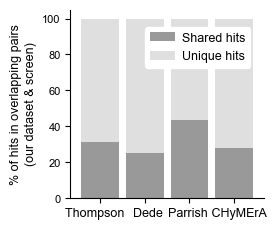

In [71]:
f, ax = plt.subplots(1, 1, figsize=(2.5,2.5))
depmap_overlap_df.plot(kind='bar', stacked=True, ax=ax, rot=0, width=0.85, color=['#999','#dfdfdf'])
gp.set_axis_props(ax, ylabel='% of hits in overlapping pairs\n(our dataset & screen)')
ax.set_xticklabels(['Thompson   ', '  Dede', 'Parrish ', '   CHyMErA'], fontsize=9)
_ = ax.legend(loc='upper right', framealpha=1, bbox_to_anchor=(0.96,0.94), handletextpad=0.5)
f.savefig("../figures/for_paper/screen_depmap_overlaps.svg", bbox_inches="tight", dpi=300)

### Hits unique to our dataset or the screen consensus pairs

FET: OR=29.8909, p=1.05e-08


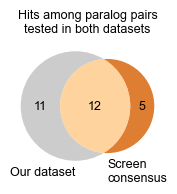

In [59]:
depmap_overlap = pd.merge(consensus_pairs[['sorted_gene_pair','SL']].rename(columns={'SL':'consensus_hit'}),
                          depmap_pairs[['sorted_gene_pair','SL']].rename(columns={'SL':'depmap_hit'}))

ctab = pd.crosstab(depmap_overlap.consensus_hit, depmap_overlap.depmap_hit)
print('FET: OR=%.4f, p=%.2e' % (stats.fisher_exact(ctab)))

# Pairs screened in both that are hits in either or both
f, ax = plt.subplots(1, 1, figsize=(2,2))
v = venn2([set(depmap_overlap[depmap_overlap.depmap_hit].sorted_gene_pair), 
           set(depmap_overlap[depmap_overlap.consensus_hit].sorted_gene_pair)],
          ['Our dataset', 'Screen\nconsensus'], ax=ax, set_colors=[data_palette[1],gp.get_color('dark-orange')], alpha=0.8)
for text in v.set_labels: text.set_fontsize(9)
_=ax.set_title('Hits among paralog pairs\ntested in both datasets', fontsize=9)